In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use("ggplot")
import plotly.express as px

#Model Creation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('ds_salaries.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


### Country Codes CSV for Map Visualization

In [3]:
country_codes = pd.read_csv('countries_codes_and_coordinates.csv')
country_codes.head(5)
country_codes.drop(columns=['Numeric code', 'Latitude (average)', 'Longitude (average)'], inplace=True)
country_codes.head(5)

,Country,Alpha-2 code,Alpha-3 code
0,Afghanistan,"""AF""","""AFG"""
1,Albania,"""AL""","""ALB"""
2,Algeria,"""DZ""","""DZA"""
3,American Samoa,"""AS""","""ASM"""
4,Andorra,"""AD""","""AND"""


## Splitting the Data

In [4]:
df_train, df_test = train_test_split(df)

In [5]:
print('Training set: \n', "Rows: ", df_train.shape[0], "\tColumns: ", df_train.shape[1])
print('Test set: \n', "Rows: ", df_test.shape[0], "\tColumns: ", df_test.shape[1])

Training set: 
 Rows:  2816 	Columns:  11
Test set: 
 Rows:  939 	Columns:  11


## Data Exploration

### General Data 

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2816 entries, 243 to 3111
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           2816 non-null   int64 
 1   experience_level    2816 non-null   object
 2   employment_type     2816 non-null   object
 3   job_title           2816 non-null   object
 4   salary              2816 non-null   int64 
 5   salary_currency     2816 non-null   object
 6   salary_in_usd       2816 non-null   int64 
 7   employee_residence  2816 non-null   object
 8   remote_ratio        2816 non-null   int64 
 9   company_location    2816 non-null   object
 10  company_size        2816 non-null   object
dtypes: int64(4), object(7)
memory usage: 264.0+ KB


### Making minor adjustments to the columns

In [7]:
df_train.columns = df_train.columns.str.replace('_', ' ')
df_test.columns = df_test.columns.str.replace('_', ' ')
df_train.columns

Index(['work year', 'experience level', 'employment type', 'job title',
       'salary', 'salary currency', 'salary in usd', 'employee residence',
       'remote ratio', 'company location', 'company size'],
      dtype='object')

### Checking for null values

In [8]:
df_train.isnull().sum()

work year             0
experience level      0
employment type       0
job title             0
salary                0
salary currency       0
salary in usd         0
employee residence    0
remote ratio          0
company location      0
company size          0
dtype: int64

### Getting Cat and Num columns

In [9]:
def get_catcolumns(dataframe):
    categorical_columns = []
    
    for i in dataframe.columns:
        if(dataframe[i].dtype != np.float64 and dataframe[i].dtype != np.int64):
            categorical_columns.append(i)

    return categorical_columns

def get_numcolumns(dataframe):
    numerical_columns = []
    
    for i in dataframe.columns:
        if(dataframe[i].dtype == np.float64 or dataframe[i].dtype == np.int64):
            numerical_columns.append(i)
    
    return numerical_columns
cat_columns = get_catcolumns(df_train)
num_columns = get_numcolumns(df_train)
print('Cat:',cat_columns, '\n Num:', num_columns)

Cat: ['experience level', 'employment type', 'job title', 'salary currency', 'employee residence', 'company location', 'company size'] 
 Num: ['work year', 'salary', 'salary in usd', 'remote ratio']


## EDA

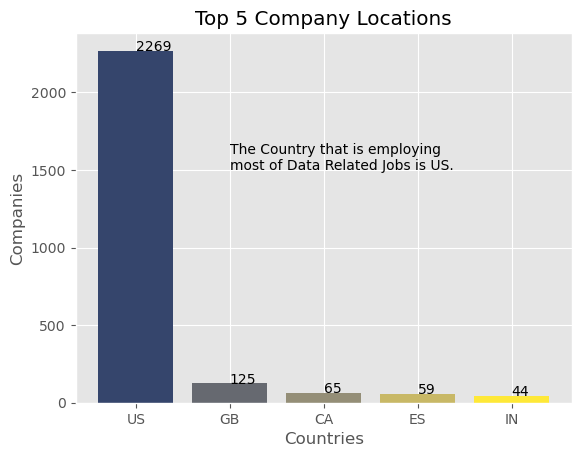

In [10]:
top_5_locations = df_train['company location'].value_counts().sort_values(ascending=False)[:5]
locations = top_5_locations.index

fig = plt.figure()
ax = plt.axes()
cmap = plt.get_cmap('cividis')
colors = cmap([0.2, 0.4, 0.6, 0.8, 1])

for i,j in zip(locations,top_5_locations):
    ax.annotate(str(j),xy=(i,j))
    
ax.bar(locations,top_5_locations, color=colors)
ax.set(title='Top 5 Company Locations', xlabel='Countries', ylabel='Companies')

#Insight Text

ax.annotate(
    f'''The Country that is employing 
most of Data Related Jobs is {locations[0]}.''',xy=(1,1500)
);

# Choosing an Effective Visual
### You should draw effective visuals for a data visualization project. In particular, you should do the following:

Identify effective visuals for your data visualization context.
Draw these visuals using any data visualization library, such as Matplotlib, Seaborn, or Plotly.
Critically evaluate your design decisions. Why are these visuals effective for conveying your message?

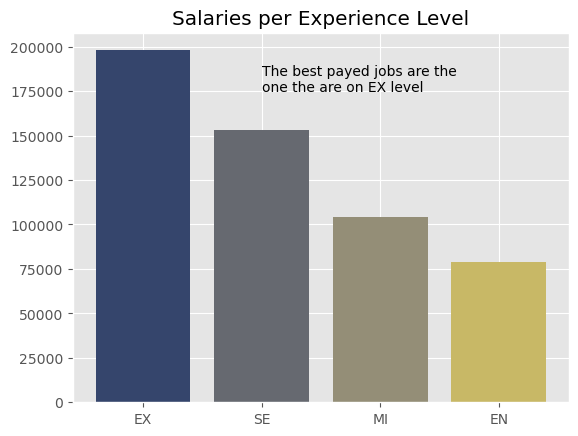

In [11]:
mean_salaries_exp = df_train.groupby('experience level')['salary in usd'].mean().sort_values(ascending=False)
index= mean_salaries_exp.index

fig = plt.figure()
ax = plt.axes()
cmap = plt.get_cmap('cividis')
colors = cmap([0.2, 0.4, 0.6, 0.8])

ax.bar(x=index, height=mean_salaries_exp, color=colors)
ax.set(title='Salaries per Experience Level')
text = f'''The best payed jobs are the 
one the are on {index[0]} level'''
ax.text(1, 175000, text, fontsize = 10);

Graph for most wanted Jobs

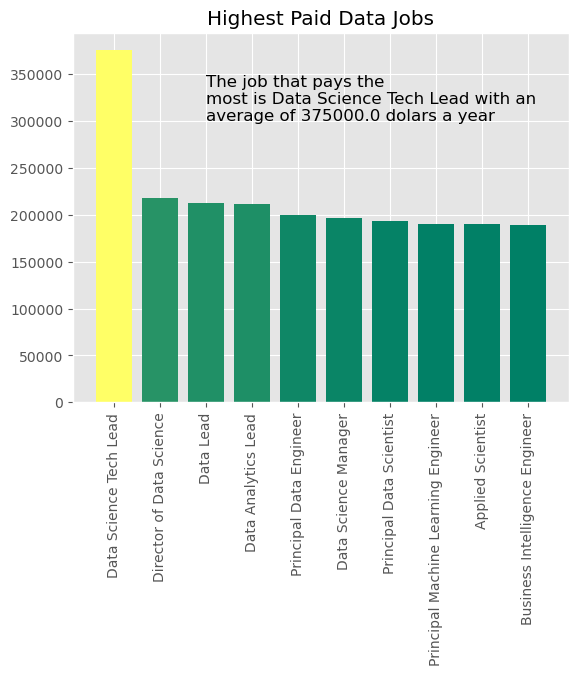

In [12]:
mean_salary_jobs = df_train.groupby('job title')['salary in usd'].mean().sort_values(ascending=False)[:10]
job_titles = mean_salary_jobs.index

# scale data for cmap
denominator = max(mean_salary_jobs) - min(mean_salary_jobs)
scaled_data = [(datum-min(mean_salary_jobs))/denominator for datum in mean_salary_jobs]

fig = plt.figure()
ax = plt.axes()

#Colors
colors = []
cmap = plt.get_cmap('summer')

for decimal in scaled_data:
    colors.append(cmap(decimal))
    
#Rotating X Labels
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
#Text
ax.set(title='Highest Paid Data Jobs')

text = f'''The job that pays the 
most is {job_titles[0]} with an 
average of {mean_salary_jobs[0]} dolars a year'''

ax.text(2,300000, text, fontsize=12)

#Showing the Graph
ax.bar(job_titles, mean_salary_jobs, color=colors);


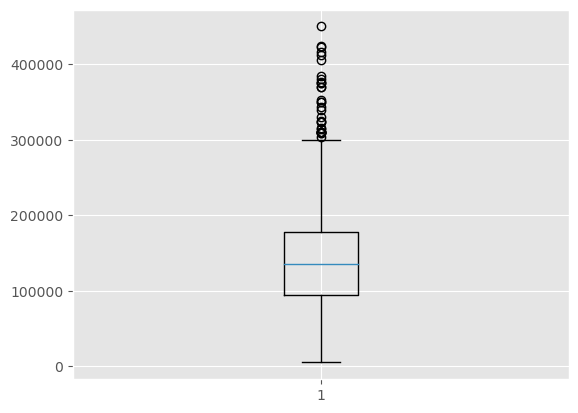

In [13]:
fig = plt.figure()
ax = plt.axes()

ax.boxplot(df_train['salary in usd']);

### Distribution of Data

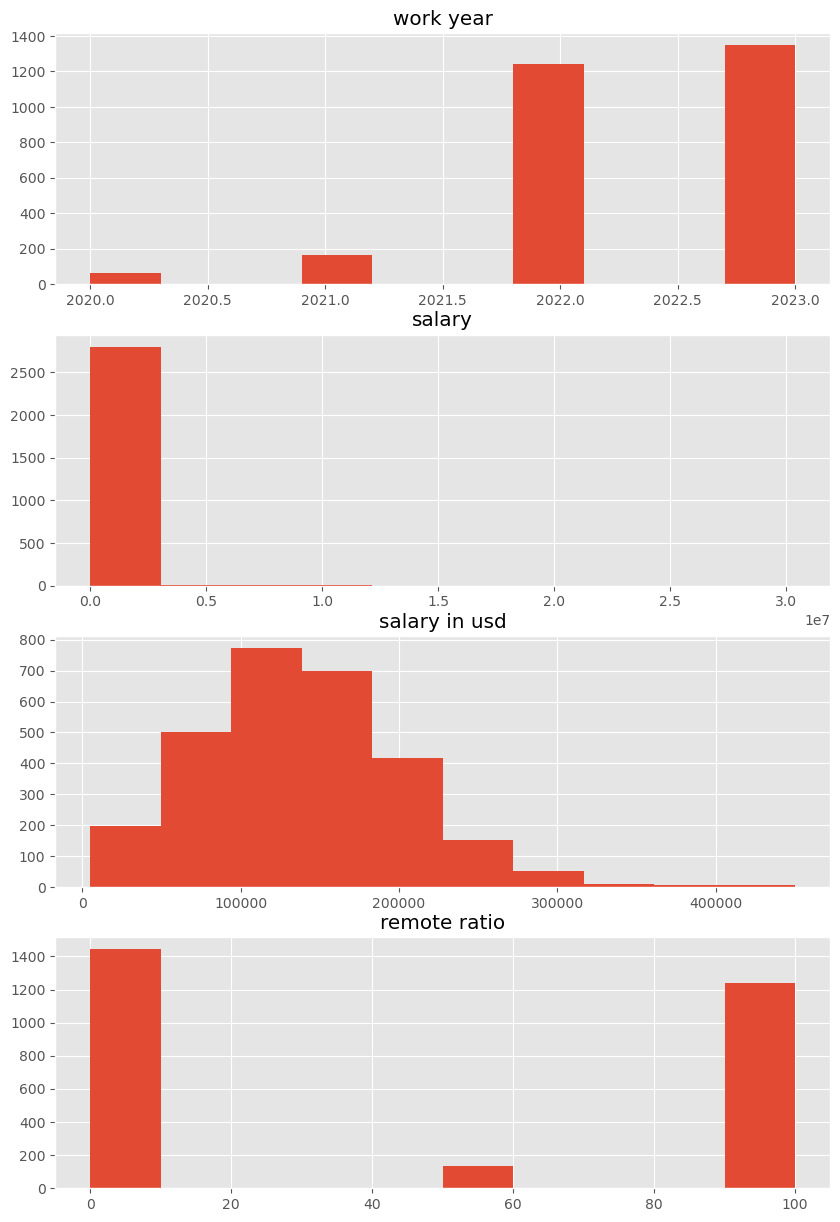

In [14]:
fig, ax = plt.subplots(4, figsize=(10, 15))

for i in range(len(num_columns)):
    ax[i].hist(df_train[num_columns[i]])
    ax[i].set(title=num_columns[i])

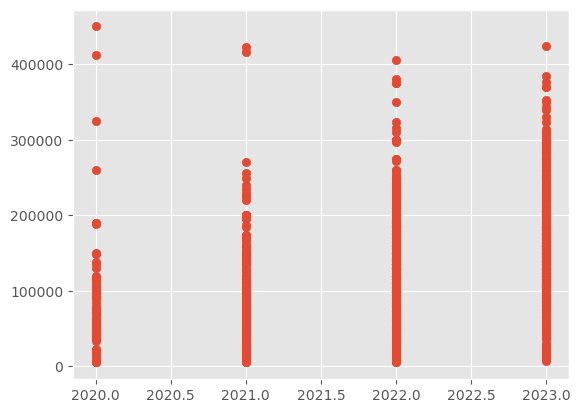

In [15]:
fig = plt.figure()
ax = plt.axes()

ax.scatter(x=df_train['work year'], y=df_train['salary in usd'])

## Data Preparation and Feature Engineering for the models

- Select Target Label in this case the target label will be salaries in dolars
- Remove Salary column and Currency column
- Change Work Year Column to Categorical data
- Normalize Numerical Data
- OneHot Encode Categorical Data



### Libraries


In [16]:
y_train = df_train['salary in usd']
y_test = df_test['salary in usd']
x_train = df_train.drop(columns=['salary in usd', 'salary','salary currency'])
x_test = df_test.drop(columns=['salary in usd', 'salary','salary currency'])

x_train['work year'] = x_train['work year'].apply(str)
x_test['work year'] = x_test['work year'].apply(str)



In [17]:
cat = get_catcolumns(x_train)
num = get_numcolumns(x_train)
ohe = OneHotEncoder(handle_unknown='ignore')
std = StandardScaler()

ct = ColumnTransformer(transformers=[('cat',ohe, cat),
                                     ('num',std, num)
                                     ], remainder='passthrough')

x_train = ct.fit_transform(x_train)
x_test = ct.transform(x_test)


## Modelling

- Linear Regression
- Ridge
- Lasso
- SVR

In [18]:
lasso = Lasso()
lasso.fit(x_train, y_train)
predict = lasso.predict(x_test)

/Users/diegoportillaamarillas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1577882484.8583984, tolerance: 1137020031.6491137
  model = cd_fast.sparse_enet_coordinate_descent(


In [19]:
np.sqrt(mean_squared_error(y_test, predict))

48738.301813894424

In [20]:
ridge = Ridge()
ridge.fit(x_train, y_train)
predict_ridge= ridge.predict(x_test)

In [21]:
np.sqrt(mean_squared_error(y_test, predict_ridge))

47220.62270858332

In [22]:
log_reg = LogisticRegression(multi_class='multinomial',solver ='lbfgs', max_iter=20000)
log_reg.fit(x_train, y_train)
predict_log_reg = log_reg.predict(x_test)

In [23]:
np.sqrt(mean_squared_error(y_test, predict_log_reg))

55151.25663856234

In [24]:
mean_squared_error(y_test, predict_log_reg)


3041661108.8125668

In [26]:
regr = RandomForestRegressor()
regr.fit(x_train, y_train)

RandomForestRegressor()

In [31]:
parameters = {'criterion':['absolute_error', 'squared_error'],
              'max_depth': [5, 10, 15], 'min_samples_split':[2, 3, 4]}

rdm_forest = RandomForestRegressor()
clf_forest = GridSearchCV(rdm_forest,parameters, scoring='neg_root_mean_squared_error')

#Train the best model on the whole training set.
clf_forest.fit(x_train,y_train)
clf_forest.best_params_

{'criterion': 'squared_error', 'max_depth': 15, 'min_samples_split': 4}

In [32]:
forest_predict = clf_forest.predict(x_test)

In [34]:
np.sqrt(mean_squared_error(y_test, forest_predict)
)

46381.17083356273